# 数据科学家纳米学位

## 卷积神经网络

## 项目：为小狗识别应用编写算法 


这个 Jupyter notebook 向你展示了优达学城最受欢迎的项目，无论在机器学习纳米学位还是人工智能纳米学位都倍受学员青睐。该项目的目标是将狗狗的图片根据品种进行分类。  

如果你想找到一个深度学习和卷积神经网络相关的且有充分指导的毕业项目的话，这就是你的首选。注意，即使你按照这个 notebook 搭建了你的分类器，你仍要写一篇博客文章或部署一个应用来满足毕业项目的要求。

注意，你其实只需要使用这个 notebook 的一部分（例如，某些代码块或数据），不需要完成整个 notebook，也能满足毕业项目的要求。

---

在此 notebook 中，我们已经为你提供一些模板代码，要成功完成此项目，你需要实现其他功能。除此之外，不需要修改所提供的代码。标题中以**（代码实现）**开头的部分表明你必须在下面的代码块中提供其他功能。我们会在每个部分提供说明，并在以 “TODO” 开头的代码块中提供实现细节。请仔细阅读说明。 

除了实现代码之外，还需要回答与项目和代码实现相关的问题。每个小节你需要回答由**'问题 X'** 开头的问题。请仔细阅读每个问题，并在**答案：**下方的文本框中填写答案。我们将根据每个问题的答案以及实现代码评估你提交的项目。

>**注意：**可以通过 **Shift + Enter** 键盘快捷键执行代码和 Markdown 单元格，并且可以通过双击单元格进入编辑模式，编辑 Markdown 单元格。

审阅标准还包含可选的“锦上添花”建议，可以指导你在满足最低要求的基础上改进项目。如果你决定实现采纳我们的建议，你应该在这个 notebook 中提供你自己的代码。



---
### 为何要完成这个项目      

在此 notebook 中，你将开发一种可用于移动应用或网络应用的算法。最终你的代码将能够接受任何用户提供的图像作为输入。如果从图像中检测出小狗，该算法将大致识别出小狗品种。如果检测出人脸，该算法将大致识别出最相似的小狗品种。下图显示了最终项目的潜在示例输出（但是我们希望每个学员的算法行为都不一样）。 

![狗狗输出示例](images/sample_dog_output.png)

在此实际应用中，你需要将一系列模型整合到一起并执行不同的任务，例如，检测图中人脸的算法与推断小狗品种的 CNN 将不一样。有很多地方都可能会出错，并且不存在完美的算法。即使你的答案不完美，也可以创造有趣的用户体验。

### 项目规划

我们将此 notebook 分成了几个独立的步骤。你可以通过以下链接浏览此 notebook。

* [第 0 步](#step0)：导入数据集
* [第 1 步](#step1)：检测人脸
* [第 2 步](#step2)：检测小狗
* [第 3 步](#step3)：（从头开始）创建分类小狗品种的 CNN
* [第 4 步](#step4)：（使用迁移学习）使用分类小狗品种的 CNN     
* [第 5 步](#step5)：（使用迁移学习）创建分类小狗品种的 CNN
* [第 6 步](#step6)：编写算法
* [第 7 步](#step7): 测试算法

---
<a id='step0'></a>


## 第 0 步：导入数据集

### 导入狗狗数据集

在下面的代码单元格中，我们将导入狗狗图片数据集我们在使用 scikit-learn 库的 `load_files` 函数时传进了很多参数：
- `train_files`, `valid_files`, `test_files` - numpy 数组，包含图片的文件路径
- `train_targets`, `valid_targets`, `test_targets` - numpy 数组，包含分类标签的独热码 
- `dog_names` - 字符串格式的狗狗品种名称列表，用于标识标签

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### 导入人类数据集

在下方的代码单元格中，我们导入人类数据集，文件路径被保存在 numpy 数组      `human_files` 中。

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## 第 1 步：检测人脸

我们使用 OpenCV 实现的 [Haar 特征级联分类器（Haar feature-based cascade classifiers）](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) 来检测图片中的人脸。OpenCV 提供了很多预训练的人脸检测器，它们以 XML 文件的形式存储在 [github](https://github.com/opencv/opencv/tree/master/data/haarcascades) 上。我们下载了其中一个检测器并存储在 `haarcascades` 目录中。

在下个代码单元格中，我们将演示如何使用此检测器从样本图像中检测人脸。

Number of faces detected: 1


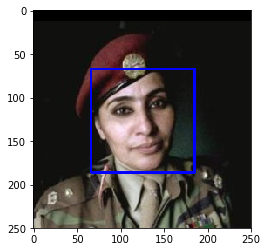

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

在使用任何人脸检测器之前，标准做法是将图像转换为灰度图像。`detectMultiScale` 函数会执行存储在 `face_cascade` 中的分类器并将灰度图像当做参数。  

在上述代码中，`faces` 是一个包含检测到的人脸的 numpy 数组，其中每行对应一张检测到的人脸。检测到的每张人脸都是一个一维数组，其中有四个条目，分别指定了检测到的人脸的边界框。数组中的前两个条目（在上述代码中提取为 `x` 和 `y`）指定了左上角边界框的水平和垂直位置。数组中的后两个条目（提取为 `w` 和 `h`）指定了边界框的宽和高。

### 编写人脸检测器

我们可以编写一个函数，如果在图像中检测到人脸，该函数将返回 `True`，否则返回 `False`。此函数称为 `face_detector`，参数为图像的字符串文件路径，并出现在以下代码块中。

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### （代码实现）评估人脸检测器

__问题 1：__ 使用以下代码单元格测试 `face_detector` 函数的性能。  
- 对于 `human_files` 中的前 100 张图像，有多少图像检测到了人脸？  
- 对于 `dog_files` 中的前 100 张图像，有多少图像检测到了人脸？ 

理想情况下，我们希望所有人脸图像都能检测到人脸，所有小狗图像都不能检测到人脸。我们的算法不能满足此目标，但是依然达到了可接受的水平。我们针对每个数据集的前 100 张图像提取出文件路径，并将它们存储在 numpy 数组 `human_files_short` 和 `dog_files_short` 中。

__答案：__
- 对于 `human_files` 中的前 100 张图像，100张图像检测到了人脸  
- 对于 `dog_files` 中的前 100 张图像，有11张图像检测到了人脸

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

#20200328
human_count_1=0
human_count_2=0
for img in human_files_short:
    if face_detector(img)>0:
        human_count_1 +=1

for i in dog_files_short:
    if face_detector(i)>0:
        human_count_2 +=1

print("In the first 100 images of human_files, the percentage of human face detected is {:.2f}%.".format(human_count_1))
print("In the first 100 images of dog_files, the percentage of human face detected is {:.2f}%.".format(human_count_2))
# end

In the first 100 images of human_files, the percentage of human face detected is 100.00%.
In the first 100 images of dog_files, the percentage of human face detected is 11.00%.


__问题 2：__ 所选的算法使得我们需要告诉用户我们对上传图片有要求，图片中的人脸必须清晰（避免触怒某些急性子用户）。我们期望用户能够配合，你认为这样的期望合理吗？如果你认为不合理，能否想出一种不需要用户上传的图片中必须有清晰人脸的人脸检测方法？

__答案：__
- 现实中很难这样，无法要求用户提供的拖点满足预期，因为现实中受拍摄角度、光线、设备像素等客观条件，图像质量参差不齐，甚至有些不够清晰。为了提高用户体验，降低用户使用门槛和约束，只能在图像处理算法上不算优化，如CNN。 


建议在算法中使用 OpenCV 的人脸检测器来检测人脸图像，但是你也可以尝试其他方法，尤其是利用深度学习的方法:)。请在以下代码单元格中设计并测试你自己的人脸检测算法。如果你打算深入 _选做（Optional）_ 任务，记得报告每个数据集上的表现。

In [7]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## 第 2 步：检测小狗

在这一小节，我们使用预训练的 [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) 模型来检测图片中的狗狗。我们的第一行代码下载了 ResNet-50 模型，以及在 [ImageNet](http://www.image-net.org/) 预训练后的权重信息。ImageNet 是一个庞大且常用的数据集，用于图像分类和其他视觉任务。ImageNet 包含 1000 万以上的 URL，每个都链接到包含某个对象的图像，这些对象分成了 [1000 个类别](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)。输入一个图片，预训练的 ResNet-50 模型预测图片中包含了什么物体，并返回对应的标签（标签是 ImageNet 内置的一些类别）。

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### 预处理数据     

当后端使用 TensorFlow 时，Keras CNN 要求输入的是一个 4D 的 numpy 数组（我们也称之为 4 维张量），其形状为：

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

其中 `nb_samples` 表示图片 (或样本) 的数量， `rows`、 `columns` 和 `channels` 表示每个图片各自的行数、列数和通道数。  

`path_to_tensor` 函数接受一个彩色图片的文件路径字符串，返回一个适用于 Keras CNN 训练的四维张量。这个函数首先加载图片，然后将其重新调整为 $224 \times 224$ 像素的形状。接下来，图片被转成 numpy 数组，之后被整理成 4D 张量。在这个案例中，因为我们处理的是彩色图片，每个图片有 3 个通道。还有，我们处理的是单张图片，返回的张量的形状就是：

$$
(1, 224, 224, 3).
$$

`paths_to_tensor` 函数接受一个图片路径的字符串 numpy 数组，返回一个四维张量。该张量的形状是：  

$$
(\text{nb_samples}, 224, 224, 3).
$$

其中，`nb_samples` 是输入的图片路径中对应的样本数，或者说图片的数目。建议你把 `nb_samples` 认为是 3 维张量的数量（每个 3 维张量就对应数据集里的一张图片） 。

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### 用 ResNet-50 进行预测

将要输入 ResNet-50 的 4 维向量准备好后，任何 Keras 中其他的预训练过的模型需要一些额外的步骤。首先，RGB 图像的通道要重排，以转换成 BGR。所有预训练的模型都需要再进行归一化，即必须将每张图片的每个像素都减去平均像素值（$[103.939, 116.779, 123.68]$ ，按 RGB 顺序排列，是用 ImageNet 中所有图像的像素值计算得到的）。上述功能在导入的 `preprocess_input` 函数进行代码实现。如果想了解更多，可以参考 `preprocess_input` 的代码[链接](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

现在我们已经准备好输入 ResNet-50 的数据了，可以开始使用该模型来提取特征了。该功能通过 `predict` 方法实现。该方法会返回一个 numpy 数组。该数组的第 $i$ 项数值表示该模型预测此图片属于第 $i$ 个 ImageNet 分类的概率。这个功能在下面的 `ResNet50_predict_labels` 函数进行代码实现。

通过对预测概率向量取 argmax，我们得到一个整数，该整数表示该图片所属的类别的序号，我们可以使用这个[字典](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)找到类别名称。

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### 写一个小狗检测器

查看该[字典](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)后，你将发现：小狗对应的类别按顺序排列，对应的键是 151-268（含），包含从 `'Chihuahua'` 到 `'Mexican hairless'` 的所有类别。因此，为了检查某张图片是否由预训练的 ResNet-50 模型检测到狗狗，我们仅仅需要检查上面的`ResNet50_predict_labels` 函数是否返回了介于 151 和 268 之间的一个数（含边界值）。

我们顺着该思路完成下面的 `dog_detector` 函数，如果检测到图片中有狗狗，它会返回 `True` （如果没有，返回 `False` ）。

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### （代码实现）评估小狗检测器

__问题 3：__ 在以下代码单元格中测试 `dog_detector` 的效果。  
- 对于 `human_files_short` 中的图像，有多少图像检测到了小狗？  
- 对于 `dog_files_short` 中的图像，有多少图像检测到了小狗？

__答案：__
- 对于 `human_files_short` 中的图像，有0%图像检测到了小狗  
- 对于 `dog_files_short` 中的图像，100%图像检测到了小狗

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
#20200328
dog_count_1=0
dog_count_2=0
for img in human_files_short:
    if dog_detector(img):
        dog_count_1 +=1

for i in dog_files_short:
    if dog_detector(i):
        dog_count_2 +=1

print("In the images of human_files_short, the percentage of dogs detected is {:.2f}%".format(dog_count_1))
print("In the images of dog_files_short, the percentage of dogs detected is {:.2f}%.".format(dog_count_2))
#end

In the images of human_files_short, the percentage of dogs detected is 0.00%
In the images of dog_files_short, the percentage of dogs detected is 100.00%.


---
<a id='step3'></a>
## 第 3 步：（从头开始）创建分类小狗品种的 CNN

创建好从图像中检测人脸和小狗的函数后，我们需要预测图像中的小狗品种。在这一步，你需要创建一个分类小狗品种的 CNN。你必须从头创建一个 CNN（因此暂时不能使用迁移学习），并且测试准确率必须至少达到 1%。在此 notebook 的第 5 步，你将使用迁移学习创建 CNN，并且能够获得很高的准确率。

谨慎添加可训练的层！更多的参数意味着更多的训练时长，意味着你更可能需要 GPU 来加速训练过程。幸运的是，Keras 提供了每个周期（epoch）训练时间的简单估计，你可以用这个乘以训练次数得到训练整个模型的时间。 

预测图中小狗的品种是一项非常难的挑战。因为 **即使人类** 要分辨布列塔尼猎犬（Brittany）和威尔斯激飞猎犬（Welsh Springer Spaniel）也很困难。  

布列塔尼猎犬 | 威尔斯激飞猎犬
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

还有很多其他相似的狗品种（例如卷毛寻回犬 Curly-Coated Retrievers 和美国水猎犬 American Water Spaniels）。  

卷毛寻回犬 | 美国水猎犬
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


还有，拉布拉多有黄色、巧克力色和黑色品种。基于视觉的算法需要克服这种同一类别差异很大的问题，并决定如何将所有这些不同肤色的小狗分类为相同的品种。  

黄色拉布拉多 | 巧克力色拉布拉多 | 黑色拉布拉多
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

随机猜测的效果很差：除了类别数量不太平衡之外，随机猜测的正确概率约为 1/133，准确率不到 1%。  

在深度学习领域，实践比理论知识靠谱得到。请尝试多种不同的架构，并相信你的直觉。希望你可以从学习中获得乐趣！ 

### 预处理数据

我们通过将每个图像中的每个像素除以 255 来重新缩放图像。

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 126.25it/s]


### （代码实现）模型架构

创建分类小狗品种的 CNN。在代码单元格的末尾，使用下面的命令来展示模型概述信息：
    
        model.summary()

我们已经导入了部分 Python 模块方便你开始，你也可以自由添加你想要添加的模块。如果你卡住了，这里提醒一下，你的模型应该做到在 CPU 上训练相对较快并且训练 5 个周期（epoch）内的准确率 >1%：

![CNN样例](images/sample_cnn.png)
           
__问题 4：__ 列出获得最终 CNN 结构的步骤以及每步的推理过程。如果你选择使用上述的结构，描述你为什么认为该 CNN 架构会在这个图像分类任务中表现优秀。

__答案：__
- 1）	构建一个 CNN，输入层接受的是 224 x 224 x 3（对应于高 224、宽 224、深 3的三维数组）的图片。第一层卷积层具有 16 个过滤器，每个宽和高分       别为 2。在进行卷积操作时，过滤器每次跳转 1 个像素，激活函数采用ReLU
- 2）	添加最大池化层，降低卷积层的维度，在最大池化层中使用 2x2 窗口
- 3）	依次增加卷积层和最大池化层
- 4）	添加全局平均池化层
- 5）	输出是133个狗狗种类，使用softmax激活函数

- 整个网络设计分别用卷积层来进行特征提取，池化层对输入的特征图进行压缩，一方面使特征图变小，简化网络计算复杂度；一方面进行特征压缩，提取主要特征。全连接层连接所有的特征，将输出值送给分类器，解决了图片数据计算维度大的问题，也考虑了像素之间的位置关系信息。

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
#20200328
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))   
#end

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### 编译模型

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### （代码实现）训练模型

在下面的代码单元格中训练你的模型。使用模型检查点来保存验证损失最低的模型信息。

欢迎你[增加训练数据](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，但这不是必须的。

In [16]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 22s 3ms/step - loss: 4.8830 - acc: 0.0100 - val_loss: 4.8660 - val_acc: 0.0120
Epoch 2/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8570 - acc: 0.0133 - val_loss: 4.8423 - val_acc: 0.0168
Epoch 3/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8144 - acc: 0.0160 - val_loss: 4.8084 - val_acc: 0.0275
Epoch 4/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7812 - acc: 0.0184 - val_loss: 4.7800 - val_acc: 0.0180
Epoch 5/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7546 - acc: 0.0195 - val_loss: 4.7637 - val_acc: 0.0192
Epoch 6/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7258 - acc: 0.0246 - val_loss: 4.7461 - val_acc: 0.0251
Epoch 7/10
6680/6680 [==============================] - 21s 3ms/step - loss: 4.6983 - acc: 0.0260 - val_loss: 4.7333 - val_acc: 0.0240
Epoch 8/

### 加载验证损失最低的模型

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### 训练模型

在小狗图像测试数据集上尝试模型。确保测试准确率高于 1%。

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.3062%


---
<a id='step4'></a>
## 第 4 步：使用 CNN 分类小狗品种

为了在不牺牲准确率的情况下减少训练时间，我们将向你展示如何使用迁移学习的方法训练 CNN。在下面的步骤中，你将亲自动手用迁移学习的方法训练自己的 CNN。

### 获取瓶颈特征（bottleneck feature）

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### 模型架构

这个模型使用预训练的 VGG-16 模型作为固定的特征提取器（fixed feature extractor），也就是说，VGG-16 的最后一层卷积层的输出会作为我们模型的输入。我们仅仅加入了一层全局平均池化层（global average pooling layer）和一个全连接层（fully connected layer），后者包含一个节点，该节点和所有狗狗品种的节点相连，并使用 softmax 激活函数。

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### 编译模型

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 训练模型

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 303us/step - loss: 11.2368 - acc: 0.1510 - val_loss: 9.5085 - val_acc: 0.2707
Epoch 2/20
6680/6680 [==============================] - 2s 249us/step - loss: 8.5101 - acc: 0.3563 - val_loss: 8.5015 - val_acc: 0.3653
Epoch 3/20
6680/6680 [==============================] - 2s 255us/step - loss: 7.8565 - acc: 0.4352 - val_loss: 8.2310 - val_acc: 0.3880
Epoch 4/20
6680/6680 [==============================] - 2s 264us/step - loss: 7.6041 - acc: 0.4760 - val_loss: 8.1914 - val_acc: 0.3988
Epoch 5/20
6680/6680 [==============================] - 2s 269us/step - loss: 7.4289 - acc: 0.4954 - val_loss: 7.9809 - val_acc: 0.4287
Epoch 6/20
6680/6680 [==============================] - 2s 268us/step - loss: 7.3105 - acc: 0.5184 - val_loss: 7.9647 - val_acc: 0.4347
Epoch 7/20
6680/6680 [==============================] - 2s 254us/step - loss: 7.2543 - acc: 0.5271 - val_loss: 7.9048 - val_acc: 0.4443


### 加载验证损失最低的模型

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### 训练模型

现在你可以使用 CNN 来测试它在测试集上识别狗狗品种的表现如何了。我们在下面打印出准确率结果。

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.5215%


### 使用模型预测狗狗的品种

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## 第 5 步：（使用迁移学习）创建分类小狗品种的 CNN

现在你将使用迁移学习创建能够识别图中小狗品种的 CNN。你的 CNN 必须在测试集上至少达到 60% 的准确率。

在第 4 步，我们用迁移学习技术从 VGG-16 瓶颈特征创建了一个 CNN 。在这一节，我们要用到不同的预训练的模型的瓶颈特征。为了让任务更简单些，我们预先计算了所有 Keras 实现了的网络的特征：
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) 瓶颈特征
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) 瓶颈特征
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) 瓶颈特征
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) 瓶颈特征

文件名的格式满足：

    Dog{network}Data.npz
    
其中上面 `{network}` 的模型名可以是 `VGG19`、 `Resnet50`  、`InceptionV3` 或 `Xception` 的任意一个。上述的模型架构中选择一个，下载对应的瓶颈特征，然后把下载的文件放入 `bottleneck_features/` 文件夹中。

### （代码实现） 获取瓶颈特征（bottleneck feature）

在下方的代码块中，用如下函数提取训练、测试和验证集的瓶颈特征：

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']
    

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

In [27]:
### TODO: Obtain bottleneck features from Xception.20200328
bottleneck_features = np.load('/data/bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [28]:
import os
# read filenames find
file_names = os.listdir("/../home/workspace/dog-project")
print(file_names)
file_names1 = os.listdir("/../data/bottleneck_features")
print(file_names1)

['dog_app-zh.ipynb', 'CODEOWNERS', 'README.md', 'saved_models', 'bottleneck_features', 'haarcascades', 'requirements', 'LICENSE.txt', 'extract_bottleneck_features.py', 'dog_app.ipynb', '.gitignore', '.ipynb_checkpoints', 'images', '__pycache__']
['DogInceptionV3Data.npz', 'DogXceptionData.npz', 'DogVGG19Data.npz', 'DogResnet50Data.npz', 'DogVGG16Data.npz']


### （代码实现）模型架构

创建分类小狗品种的 CNN。在代码单元格末尾，运行下面这行代码返回模型的概述信息：

In [29]:
<your model's name>.summary()

SyntaxError: invalid syntax (<ipython-input-29-25f36fb515ad>, line 1)

__问题 5：__列出获得最终 CNN 结构的步骤以及每步的推理过程。解释为何该结构适合解决手头的问题。

__答案：__
- 下载预训练的模型的bottleneck feature
- 使用预训练的 Xception 模型作为固定的特征提取器（fixed feature extractor），Xception的最后一层卷积层的输出会作为我们模型的输入。
- 加入了一层全局平均池化层（global average pooling layer）和一个全连接层（fully connected layer），后者包含一个节点，该节点和所有狗狗品种的节点相连，并使用 softmax 激活函数
- 这里使用迁移学习对提前训练过的神经网络进行调整，以用于新的不同数据集

In [30]:
### TODO: Define your architecture.
### TODO: Define your architecture using Xception
from keras.applications import Xception

Xception_model_transfer = Sequential()
Xception_model_transfer.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model_transfer.add(Dense(133, activation='softmax'))

Xception_model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [31]:
Xception_model_transfer_p1=Xception_model_transfer
Xception_model_transfer_p2=Xception_model_transfer
Xception_model_transfer_p3=Xception_model_transfer
Xception_model_transfer_p4=Xception_model_transfer

### （代码实现） 编译该模型

In [32]:
### TODO: Compile the model.
### TODO: Compile the model using Xception
Xception_model_transfer.compile(loss='categorical_crossentropy', 
                             optimizer='rmsprop', 
                             metrics=['accuracy'])

### （代码实现） 训练模型

在下面的代码单元格中训练模型。使用模型检查点来保存验证损失最低的模型。  

欢迎你[增加训练数据](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)，但这不是必须的。

In [33]:
### TODO: Train the model.
### TODO: Train the model using Xception.
from keras.callbacks import ModelCheckpoint,EarlyStopping  
earlystopping = EarlyStopping(monitor='val_loss', patience=2) # Early stop the fitting if the loss doesn't improve anymore
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping,checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 460us/step - loss: 1.0500 - acc: 0.7368 - val_loss: 0.5207 - val_acc: 0.8371
Epoch 2/20
6680/6680 [==============================] - 3s 387us/step - loss: 0.3985 - acc: 0.8749 - val_loss: 0.5041 - val_acc: 0.8323
Epoch 3/20
6680/6680 [==============================] - 3s 387us/step - loss: 0.3243 - acc: 0.9006 - val_loss: 0.4884 - val_acc: 0.8479
Epoch 4/20
6680/6680 [==============================] - 3s 381us/step - loss: 0.2776 - acc: 0.9129 - val_loss: 0.5287 - val_acc: 0.8395
Epoch 5/20
6680/6680 [==============================] - 3s 389us/step - loss: 0.2440 - acc: 0.9231 - val_loss: 0.5243 - val_acc: 0.8611


### （代码实现）加载验证损失最低的模型

In [34]:
### TODO: Load the model weights with the best validation loss.
Xception_model_transfer.load_weights('saved_models/weights.best.Xception.hdf5')

### （代码实现）测试模型

在小狗图像测试数据集上尝试模型。确保测试准确率高于 60%。

In [35]:
### TODO: Calculate classification accuracy on the test dataset.
Xception_predictions = [np.argmax(Xception_model_transfer.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception: %.4f%%' % test_accuracy)

Test accuracy using Xception: 84.5694%


In [48]:
### TODO: Compile the model using Xception, change the optimizer into Adam
Xception_model_transfer_p1.compile(loss='categorical_crossentropy', 
                             optimizer='Adam', 
                             metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer_p1.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Xception_model_transfer_p1.load_weights('saved_models/weights.best.Xception.hdf5')

Xception_predictions = [np.argmax(Xception_model_transfer_p1.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_1 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception with Adam: %.4f%%' % test_accuracy_1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0114 - acc: 0.9975 - val_loss: 0.7918 - val_acc: 0.8455
Epoch 2/20
6680/6680 [==============================] - 4s 558us/step - loss: 0.0083 - acc: 0.9979 - val_loss: 0.7414 - val_acc: 0.8467
Epoch 3/20
6680/6680 [==============================] - 4s 590us/step - loss: 0.0079 - acc: 0.9981 - val_loss: 0.7349 - val_acc: 0.8587
Epoch 4/20
6680/6680 [==============================] - 4s 546us/step - loss: 0.0077 - acc: 0.9981 - val_loss: 0.7724 - val_acc: 0.8479
Epoch 5/20
6680/6680 [==============================] - 4s 551us/step - loss: 0.0067 - acc: 0.9985 - val_loss: 0.7413 - val_acc: 0.8587
Test accuracy using Xception with Adam: 85.6459%


In [46]:
### TODO: Compile the model using Xception, change the optimizer into Nadam
Xception_model_transfer_p2.compile(loss='categorical_crossentropy', 
                             optimizer='Nadam', 
                             metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer_p2.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Xception_model_transfer_p2.load_weights('saved_models/weights.best.Xception.hdf5')

Xception_predictions = [np.argmax(Xception_model_transfer_p2.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_2 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception with Nadam: %.4f%%' % test_accuracy_2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0651 - acc: 0.9780 - val_loss: 0.7923 - val_acc: 0.8311
Epoch 2/20
6680/6680 [==============================] - 4s 598us/step - loss: 0.0269 - acc: 0.9913 - val_loss: 0.7209 - val_acc: 0.8431
Epoch 3/20
6680/6680 [==============================] - 4s 565us/step - loss: 0.0230 - acc: 0.9927 - val_loss: 0.7258 - val_acc: 0.8479
Epoch 4/20
6680/6680 [==============================] - 4s 574us/step - loss: 0.0162 - acc: 0.9960 - val_loss: 0.7491 - val_acc: 0.8455
Test accuracy using Xception with Nadam: 84.3301%


In [38]:
### TODO: Compile the model using Xception, change the optimizer into sgd
Xception_model_transfer_p3.compile(loss='categorical_crossentropy', 
                             optimizer='sgd', 
                             metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer_p3.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Xception_model_transfer_p3.load_weights('saved_models/weights.best.Xception.hdf5')

Xception_predictions = [np.argmax(Xception_model_transfer_p3.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_3 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception with sgd: %.4f%%' % test_accuracy_3)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 441us/step - loss: 0.0229 - acc: 0.9942 - val_loss: 0.5981 - val_acc: 0.8467
Epoch 2/20
6680/6680 [==============================] - 3s 386us/step - loss: 0.0183 - acc: 0.9961 - val_loss: 0.5932 - val_acc: 0.8515
Epoch 3/20
6680/6680 [==============================] - 3s 375us/step - loss: 0.0161 - acc: 0.9970 - val_loss: 0.5905 - val_acc: 0.8551
Epoch 4/20
6680/6680 [==============================] - 3s 376us/step - loss: 0.0148 - acc: 0.9976 - val_loss: 0.5891 - val_acc: 0.8539
Epoch 5/20
6680/6680 [==============================] - 3s 379us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.5880 - val_acc: 0.8551
Epoch 6/20
6680/6680 [==============================] - 3s 386us/step - loss: 0.0133 - acc: 0.9984 - val_loss: 0.5872 - val_acc: 0.8575
Epoch 7/20
6680/6680 [==============================] - 2s 372us/step - loss: 0.0129 - acc: 0.9984 - val_loss: 0.5865 - val_acc: 0.8575
E

In [39]:
### TODO: Compile the model using Xception, change the optimizer into RMSprop
Xception_model_transfer_p4.compile(loss='categorical_crossentropy', 
                             optimizer='RMSprop', 
                             metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model_transfer_p4.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[earlystopping, checkpointer], verbose=1)

Xception_model_transfer_p4.load_weights('saved_models/weights.best.Xception.hdf5')

Xception_predictions = [np.argmax(Xception_model_transfer_p4.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
# report test accuracy
test_accuracy_4 = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy using Xception with RMSprop: %.4f%%' % test_accuracy_4)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 469us/step - loss: 0.0191 - acc: 0.9966 - val_loss: 0.6006 - val_acc: 0.8587
Epoch 2/20
6680/6680 [==============================] - 3s 382us/step - loss: 0.0166 - acc: 0.9961 - val_loss: 0.6057 - val_acc: 0.8599
Epoch 3/20
6680/6680 [==============================] - 3s 392us/step - loss: 0.0166 - acc: 0.9961 - val_loss: 0.6217 - val_acc: 0.8647
Test accuracy using Xception with RMSprop: 85.4067%


### （代码实现）使用模型预测小狗品种

编写一个函数，它会将图像路径作为输入，并返回模型预测的小狗品种（`Affenpinscher`、`Afghan_hound` 等）。  

类似于第 5 步的函数，你的函数应该分 3 步：
1. 提取所选择的 CNN 模型的瓶颈特征。
2. 将瓶颈特征作为模型的输入返回预测向量。注意预测向量的 argmax 就是预测的狗狗品种的序号。
3. 使用 notebook 中第 0 步定义的 `dog_names` 数组来返回对应的狗狗品种。

用来提取瓶颈特征（即利用网络的卷积层部分，把全连接以上的部分抛掉。然后在我们的训练集和测试集上跑一遍，将得到的输出。即网络在全连接之前的最后一层激活的 feature map）的函数可以在 `extract_bottleneck_features.py` 找到，并且它们已经在前面的单元格中导入了。为了得到你的 CNN 的瓶颈特征，你需要使用函数：

In [40]:
extract_{network}

SyntaxError: invalid syntax (<ipython-input-40-fccabf88c429>, line 1)

其中上面的 `{network}` 模型名应该是 `VGG19`、`Resnet50`、`InceptionV3` 和 `Xception` 其中之一。

In [41]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    dog_names[np.argmax(dog_breed_predicted)] - strings of predicted dog names 
    
    Description:
    extract bottleneck features from the image path, use the selected model to obtain the predicted vector,
    and return dog breed that is predicted by the model
    '''
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    dog_breed_predicted = Xception_model_transfer_p4.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(dog_breed_predicted)]

---
<a id='step6'></a>
## 第 6 步：编写算法

编写一个算法，它会将图像的文件路径作为输入，并首先判断图像中是否包含人脸、小狗，或二者都不含。然后，
- 如果在图像中检测到了__小狗__，则返回预测的品种。
- 如果在图像中检测到了__人脸__，则返回相似的小狗品种。
- 如果二者都没检测到，则输出错误消息。

你可以自己编写从图像中检测人脸和小狗的函数，当然也可以使用上面开发的 `face_detector` 和 `dog_detector` 函数。你**必须**使用在第 5 步创建的 CNN 预测小狗品种。  

下方是函数所需的输入样本图片和输出 ，你也可以自由地设计流程获得更好的用户体验。

![人脸样本输出](images/sample_human_2.png)

这张图片看起来像     阿富汗猎犬（Afghan Hound）。
### （代码实现）编写算法

In [42]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def predict_breed(img_path):
    '''
    INPUT:
    img_path - a url path to the image
    
    OUTPUT:
    if a dog is detected, print"Hello, dogs" and the predicted dog breed, and the image is shown
    if a human is detected, print"Hello, humans" and the predicted dog breed they resemble most, and the image is shown
    if neither a dog nor a human is detected, print"You are neither dogs nor humans.", the image is shown

    Description:
    if a dog is detected, print"Hello, dogs" and the predicted dog breed;
    if a human is detected, print"Hello, humans" and the predicted dog breed they resemble most
    if neither a dog nor a human is detected, print"You are neither dogs nor humans."
    The images we predicted on are shown meanwhile
    '''
    #image processing    
    print("look at this picture:")
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    plt.imshow(cv_rgb)
    plt.show()
    
    if dog_detector(img_path):
        print("Hello, dogs!")
        breed = Xception_predict_breed(img_path)[15:-1]
        print("You are a {}.".format(breed))
    
    elif face_detector(img_path):        
        print("Hello, humans!")
        breed = Xception_predict_breed(img_path)[15:-1]
        print("If you were a dog, you are a {}.".format(breed))
    
    else:
        print("You are neither dogs nor humans.")
    


---
<a id='step7'></a>
## 第 7 步：测试算法

在此部分中，你可以尽情测试新算法啦！ 算法认为 __这__ 看起来和哪个品种的狗狗比较像？如果你有一只狗，算法能准确预测出小狗的品种吗？如果你有一只猫，算法会错误地认为这只猫是小狗吗？

### （代码实现）在样本图像上测试算法。

至少在计算机上用 6 张图像测试你的算法。你可以使用任何图像。至少测试两张人脸图像和两张小狗图像。  

__问题 6：__ 结果比你预期的要好吗 :)？ 还是更糟糕 :(？请对你的算法提出至少三个值得改进的地方。

__答案：__ 
- 结果比预期的要好，人脸识别存在一定误差，容易将小狗头像识别成人脸
- 可以尝试新的预训练模型，InceptionResNetV2, MobileNet, DenseNet 等等
- 模型参数进行调整，尝试不同优化器的参数，不同损失函数、学习速率等等
- 增加高质量的训练数据

In [53]:
file_names = os.listdir("images/")
print(file_names)

['dog2.jpg', 'dog1.jpg', 'tiger.jpg', 'Welsh_springer_spaniel_08203.jpg', 'sample_human_output.png', 'Labrador_retriever_06457.jpg', 'Curly-coated_retriever_03896.jpg', 'sample_cnn.png', 'Brittany_02625.jpg', 'cat.jpg', 'dog3.jpg', 'sample_human_2.png', 'Labrador_retriever_06449.jpg', 'American_water_spaniel_00648.jpg', 'wolf.jpg', 'sample_dog_output.png', '.ipynb_checkpoints', 'Labrador_retriever_06455.jpg']


look at this picture:


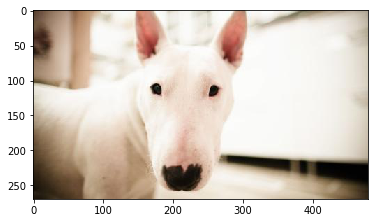

Hello, dogs!
You are a Bull_terrie.
look at this picture:


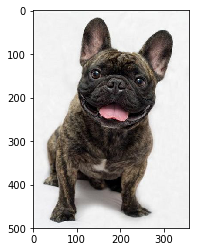

Hello, dogs!
You are a French_bulldo.
look at this picture:


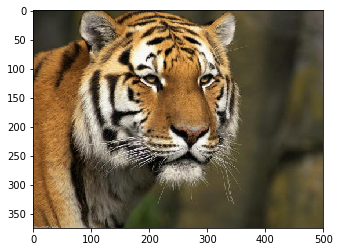

Hello, humans!
If you were a dog, you are a Bulldo.
look at this picture:


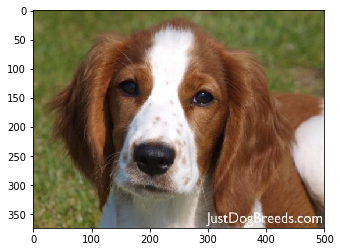

Hello, dogs!
You are a Welsh_springer_spanie.
look at this picture:


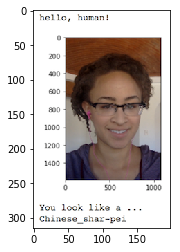

Hello, humans!
If you were a dog, you are a American_staffordshire_terrie.
look at this picture:


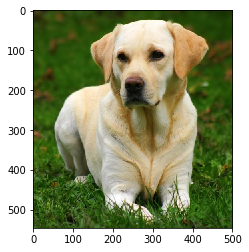

Hello, dogs!
You are a Labrador_retrieve.
look at this picture:


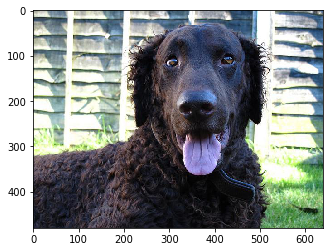

Hello, dogs!
You are a Curly-coated_retrieve.
look at this picture:


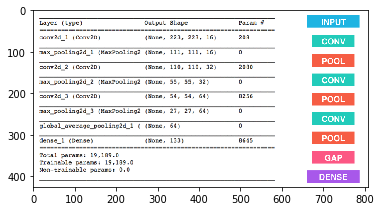

You are neither dogs nor humans.
look at this picture:


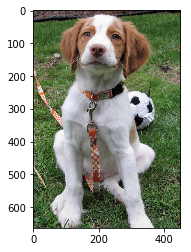

Hello, dogs!
You are a Brittan.
look at this picture:


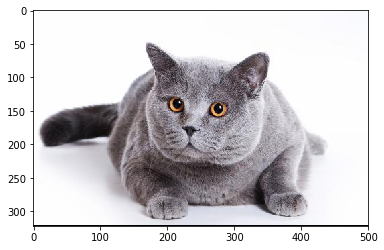

You are neither dogs nor humans.
look at this picture:


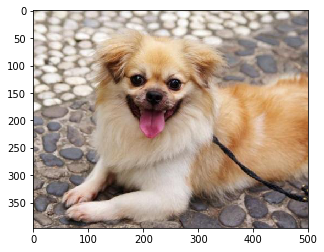

Hello, dogs!
You are a Pekinges.
look at this picture:


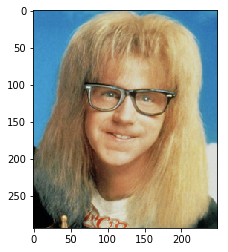

Hello, humans!
If you were a dog, you are a Dachshun.
look at this picture:


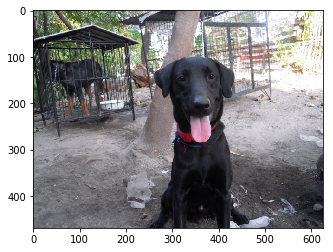

Hello, dogs!
You are a Labrador_retrieve.
look at this picture:


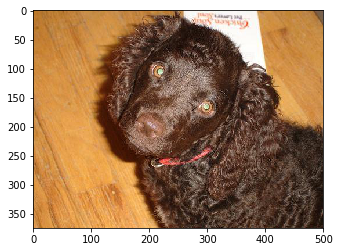

Hello, dogs!
You are a American_water_spanie.
look at this picture:


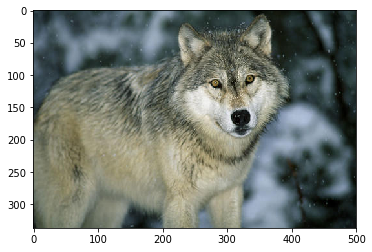

You are neither dogs nor humans.
look at this picture:


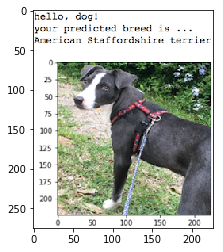

You are neither dogs nor humans.
look at this picture:


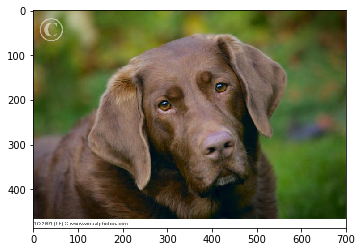

Hello, dogs!
You are a Labrador_retrieve.


In [54]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
for file_name in file_names:
    if(file_name.endswith(('.jpg','.png'))):
        predict_breed('images/'+file_name)